# PGA Success Predictor

## Imports and Installations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Cal Poly SLO/Graduate Program/CSC 570 (2)/Team Project'
%ls

Mounted at /content/drive
/content/drive/MyDrive/Cal Poly SLO/Graduate Program/CSC 570 (2)/Team Project
 data_handler.py  'PGA Succ.ipynb'   pgaTourData.csv   __pycache__/


In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [55]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [4]:
from data_handler import import_dataset

## Data Processing
Player Name is used as an index (as it should be used as an identifier and not a feature) and all values are scaled with Min-Max in case data is not a normal distribution

In [67]:
X, y = import_dataset('pgaTourData.csv', split_train_test=False)
names = X['Player Name']
X.index = names
y.index = names
X = X.drop(['Player Name'], axis=1)
features = X.columns
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=names, columns=features)
Xy = X.join(y)
Xy.dropna()
Xy.index.name = None
Xy = Xy.sample(frac=1)
Xy

,Rounds,Fairway Percentage,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Top 10
Nicholas Thompson,0.573333,0.620791,0.427767,0.716717,0.770774,0.212085,0.546650,0.067451,0.0,0.226488,0.415672,0.617739,0.548086,0.376730,1.0
Jimmy Walker,0.520000,0.270526,0.602251,0.627127,0.389685,0.656003,0.286566,0.238358,0.0,0.672169,0.737133,0.561836,0.649549,0.688050,4.0
Robert Allenby,0.413333,0.481985,0.380863,0.613113,0.687679,0.270142,0.465977,0.099376,0.0,0.401919,0.460018,0.396002,0.690009,0.405031,1.0
Rod Pampling,0.226667,0.610455,0.412758,0.455455,0.515759,0.500000,0.657138,0.014642,0.0,0.404607,0.376670,0.506558,0.393713,0.482390,0.0
Jason Kokrak,0.720000,0.444182,0.808630,0.842342,0.595989,0.438389,0.306208,0.167307,0.0,0.574664,0.667498,0.648657,0.602863,0.521384,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Marc Leishman,0.560000,0.453337,0.536585,0.657157,0.553009,0.509084,0.363206,0.176428,0.0,0.510173,0.645948,0.559338,0.652661,0.630189,4.0
William McGirt,0.773333,0.733904,0.262664,0.716216,0.415473,0.793049,0.341810,0.155785,0.0,0.589251,0.652538,0.563398,0.541550,0.740881,3.0
Sean O'Hair,0.293333,0.504135,0.681051,0.515516,0.418338,0.535150,0.487724,0.099376,0.0,0.486756,0.530009,0.602124,0.500156,0.481761,5.0
Cameron Tringale,0.293333,0.264914,0.429644,0.599600,0.659026,0.443523,0.604700,0.020403,0.0,0.526296,0.390027,0.114304,0.631186,0.640252,4.0


## Feature Extraction
Heatmap is used to see which features are most correlated with the prediction column (Top 10). In this case, we see that Average Score, Average SG Total, and Points are the most indicative of being good features for Top 10 results. 

In [68]:
def plot_correlation(data):
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(data.corr(), linewidths=.3, annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

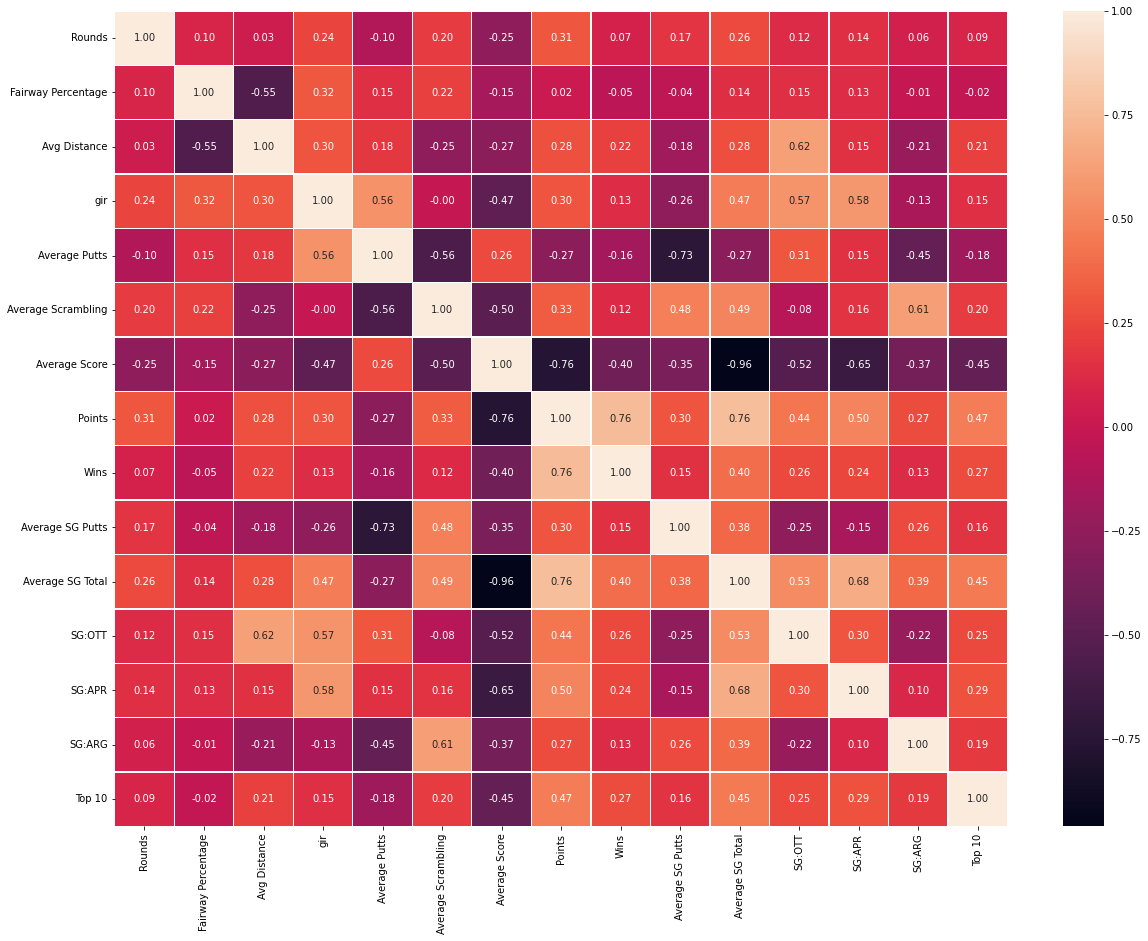

In [69]:
plot_correlation(Xy)

## Feature Selection
Selecting Average Score, Average SG Total, and Points are selected to be used as the features to train regression models due to correlation with Top 10.

In [70]:
X = Xy[['Average Score', 'Average SG Total', 'Points']]
X

,Average Score,Average SG Total,Points
Nicholas Thompson,0.546650,0.415672,0.067451
Jimmy Walker,0.286566,0.737133,0.238358
Robert Allenby,0.465977,0.460018,0.099376
Rod Pampling,0.657138,0.376670,0.014642
Jason Kokrak,0.306208,0.667498,0.167307
...,...,...,...
Marc Leishman,0.363206,0.645948,0.176428
William McGirt,0.341810,0.652538,0.155785
Sean O'Hair,0.487724,0.530009,0.099376
Cameron Tringale,0.604700,0.390027,0.020403


In [71]:
y = Xy[['Top 10']]
y

,Top 10
Nicholas Thompson,1.0
Jimmy Walker,4.0
Robert Allenby,1.0
Rod Pampling,0.0
Jason Kokrak,1.0
...,...
Marc Leishman,4.0
William McGirt,3.0
Sean O'Hair,5.0
Cameron Tringale,4.0


In [72]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=0)

## Regression Model Performances

In [73]:
def plot_regression(ytest, ypred):
    fig, ax = plt.subplots()
    ax.scatter(ypred, ytest, edgecolors=(0, 0, 1))
    ax.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', lw=3)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

In [74]:
def calculate_error(ytest, ypred):
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    r2 = r2_score(ytest, ypred)
    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))

### SVM 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model performance for testing set
--------------------------------------
MAE is 1.3867775586255378
MSE is 3.3212432763260007
R2 score is 0.259367252348465


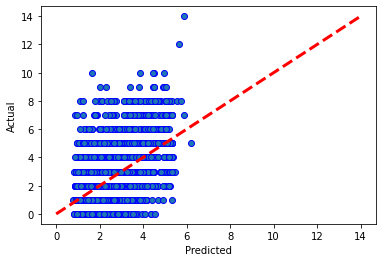

In [75]:
svm_reg = SVR(kernel='rbf')
svm_reg.fit(Xtrain,ytrain)
ypred = svm_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

### Random Forest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


The model performance for testing set
--------------------------------------
MAE is 1.4099506725652853
MSE is 3.2490372810660717
R2 score is 0.27546909139394227


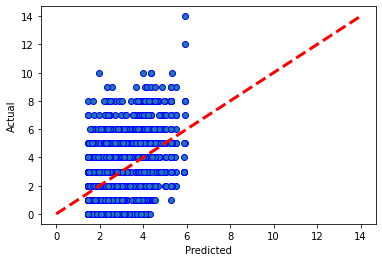

In [76]:
rf_reg = RandomForestRegressor(max_depth=3, random_state=0)
rf_reg.fit(Xtrain,ytrain)
ypred = rf_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

### Linear Regression

The model performance for testing set
--------------------------------------
MAE is 1.432241017018436
MSE is 3.347867515104873
R2 score is 0.2534300831981401


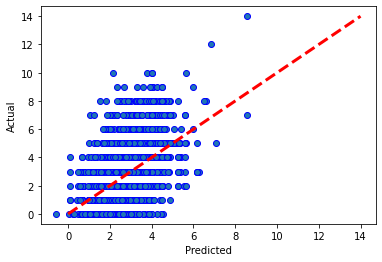

In [77]:
lin_reg = LinearRegression()
lin_reg.fit(Xtrain,ytrain)
ypred = lin_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

### Ridge Regression

The model performance for testing set
--------------------------------------
MAE is 1.4322828970380233
MSE is 3.347311140610961
R2 score is 0.2535541539559454


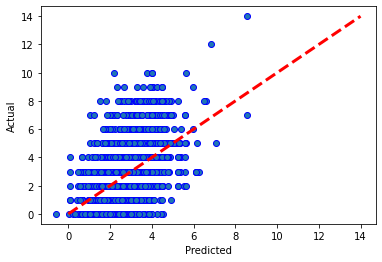

In [78]:
rdg_reg = Ridge(alpha=0.5)
rdg_reg.fit(Xtrain,ytrain)
ypred = rdg_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

### Decision Tree

The model performance for testing set
--------------------------------------
MAE is 1.4191430216300682
MSE is 3.33939775732784
R2 score is 0.2553188276990507


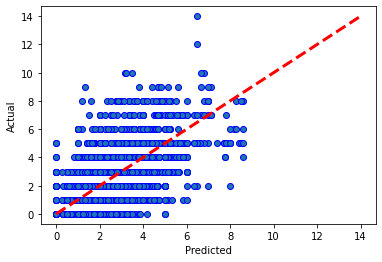

In [79]:
dt_reg = DecisionTreeRegressor(random_state=0)
dt_reg.fit(Xtrain,ytrain)
ypred = dt_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)

### Neural Network Regressor

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model performance for testing set
--------------------------------------
MAE is 1.4126369502242586
MSE is 3.2653341023605393
R2 score is 0.27183492234064144


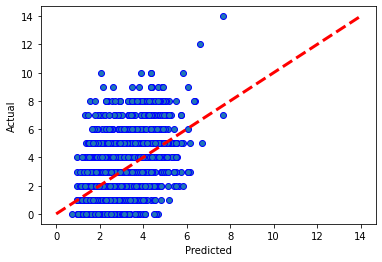

In [80]:
mlp_reg = MLPRegressor(random_state=0, max_iter=500)
mlp_reg.fit(Xtrain,ytrain)
ypred = mlp_reg.predict(Xtest)
calculate_error(ytest, ypred)
plot_regression(ytest, ypred)